# Dimensionality Reduction & Clustering

**Dimensionality reduction** is an incredibly useful tool in data science as well as neuroscience. Here, we'll explore one main method of dimensionality reduction: **Principal Components Analysis**. We'll first generate a dataset, then perform PCA step-by-step, and then learn the very simple commands to do this in Python. Lastly, we'll use *k*-means clustering to find clusters in the two-dimensional PCA data.


### By the end of this notebook, you'll be able to:
* Run PCA on high dimensional data, including electrophysiology time series
* Use *k*-means clustering to find clusters in your data
* Plot the results of your dimensionality reduction and clustering, coloring each point by either a known feature or by a cluster assignment

### About this notebook

The examples here are derived from Pascal Wallisch's *Neural Data Science* (Chapter 8), and Jake VanderPlaas's *Neural Data Science Handbook*. Inspiration for the exercises in Step 4 are from [this notebook](https://github.com/marius10p/NeuralDataScienceCSHL2019/blob/master/ByronYuExercises/exercises.pdf) from Byron Yu, featuring data from Krisha Shenoy.

<font color="red"> This needs a fresh activity; I don't think we can use these ones that are adapted. -ALJ </font>

<hr>

## Part 1: Create a dataset of 100 neurons with eight different features.

Here, we will simulate a dataset with eight different features. First, we'll decide on the 'prototype' of six different cells, for eight different features: response latency, somatic volume, cortical depth, maximum firing rate, spontaneous firing rate, spike width, axon length, and dendritic arborization area.

In [1]:
# Import our necessary toolboxes
import numpy as np
import pandas as pd
from scipy import stats

# Specify fields to generate data
generatorFields=['type_num', 'transmission', 'latMean','latStd','volMean','volStd', 'depthMean', \
                 'depthStd','maxrateMean', 'maxrateStd','spontMean','spontStd','widthMean','widthStd', \
                 'axonMean','axonStd','dendriteMean','dendriteStd']

# Specify each property value
Type1=[1, 'excitatory', 14, .5, 150,30,500,20,.9, .1,.02,.01, 1, .05, 160, 20, 180,30 ] #Cortical Layer 4 pyramid
Type2=[2, 'excitatory', 15, .5, 120,30,300,20,.8, .1,.07,.01, 1, .04, 150, 20, 150,30 ] #L2 pyramidal
Type3=[3, 'inhibitory', 15, 1, 120,30, 300,20, .95,.1,.2,.1, .2,.001,150, 10, 150,10 ] #L2 inhibitory PV+
Type4=[4, 'inhibitory', 17, 4, 110,30,300,20, .3, .1,.02, .01,.3,.005,150, 10, 150,40 ] #L2 inhibitory SOM+ 
Type5=[5, 'excitatory', 22, 5, 180,20,800,100,.35,.2,.35, .1,.5,.1, 1000, 500, 200,60 ] #L6 excitatory pyramid
Type6=[6, 'inhibitory', 13, .5, 100,30,500,20,.95,.1,.2,.1, .2,.001,150, 10, 150,10 ] #L4 inhibitory FS+

dftype = pd.DataFrame([Type1,Type2,Type3,Type4,Type5,Type6],columns=generatorFields)
dftype

,type_num,transmission,latMean,latStd,volMean,volStd,depthMean,depthStd,maxrateMean,maxrateStd,spontMean,spontStd,widthMean,widthStd,axonMean,axonStd,dendriteMean,dendriteStd
0,1,excitatory,14,0.5,150,30,500,20,0.90,0.1,0.02,0.01,1.0,0.050,160,20,180,30
1,2,excitatory,15,0.5,120,30,300,20,0.80,0.1,0.07,0.01,1.0,0.040,150,20,150,30
2,3,inhibitory,15,1.0,120,30,300,20,0.95,0.1,0.20,0.10,0.2,0.001,150,10,150,10
3,4,inhibitory,17,4.0,110,30,300,20,0.30,0.1,0.02,0.01,0.3,0.005,150,10,150,40
4,5,excitatory,22,5.0,180,20,800,100,0.35,0.2,0.35,0.10,0.5,0.100,1000,500,200,60
5,6,inhibitory,13,0.5,100,30,500,20,0.95,0.1,0.20,0.10,0.2,0.001,150,10,150,10


Now, we'll create hundred neurons that are randomly selected from these six different cell types.

In [2]:
cellFields = ['latency','volume','depth','maxrate','spont','width','axon','dendrite','transmission']
dataset = pd.DataFrame(columns = cellFields) # Inititialize our dataset

for i in range(100): # For one hundred neurons
    tt = np.random.randint(6) # Randomly choose a cell type
    trans = dftype.loc[tt,'transmission'] # Excitatory or inhibitory?
    latency = dftype.loc[tt,'latMean']+np.random.randn()*dftype.loc[tt]['latStd'] # Mean latency, with some jitter
    vol=dftype.loc[tt,'volMean']+np.random.randn()*dftype.loc[tt]['volStd'] # Mean volume, with some jitter
    z = dftype.loc[tt,'depthMean']+np.random.randn()*dftype.loc[tt]['depthStd'] # Mean depth, with some jitter
    maxrate = dftype.loc[tt,'maxrateMean']+np.random.randn()*dftype.loc[tt]['maxrateStd']
    spont = dftype.loc[tt,'spontMean']+np.random.randn()*dftype.loc[tt]['spontStd'] 
    waveWidth = dftype.loc[tt,'widthMean']+np.random.randn()*dftype.loc[tt]['widthStd']
    axon = dftype.loc[tt,'axonMean']+np.random.randn()*dftype.loc[tt]['axonStd'] 
    dendrite = dftype.loc[tt,'dendriteMean']+np.random.randn()*dftype.loc[tt]['dendriteStd']
    
    # Append each simulated property to the dataset
    dataset = dataset.append(pd.DataFrame
    ([[latency,vol,z,maxrate,spont,waveWidth,axon,dendrite,trans]],columns=cellFields),ignore_index=True)
    
print(dataset.shape)
nrows,ncolumns = dataset.shape
dataset.head()

(100, 9)


/var/folders/xf/zpnqd_3d3m77t0w3b54_8ls80000gp/T/ipykernel_88663/3536420254.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(pd.DataFrame
/var/folders/xf/zpnqd_3d3m77t0w3b54_8ls80000gp/T/ipykernel_88663/3536420254.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(pd.DataFrame
/var/folders/xf/zpnqd_3d3m77t0w3b54_8ls80000gp/T/ipykernel_88663/3536420254.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(pd.DataFrame
/var/folders/xf/zpnqd_3d3m77t0w3b54_8ls80000gp/T/ipykernel_88663/3536420254.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = data

,latency,volume,depth,maxrate,spont,width,axon,dendrite,transmission
0,12.702187,132.914624,520.705760,0.800139,0.374729,0.199383,160.339843,124.532215,inhibitory
1,10.965020,98.583961,261.797470,0.323374,0.020168,0.302280,146.068068,98.053089,inhibitory
2,20.644895,170.863569,791.959891,0.192954,0.352378,0.372249,1293.356104,182.695065,excitatory
3,12.959946,125.238397,526.838648,1.049965,0.211066,0.200038,151.886313,147.709085,inhibitory
4,13.616407,103.538847,490.695815,0.966806,0.357783,0.199404,143.704852,154.109603,inhibitory


Let's take a look at these eight different factors, and how they compare.

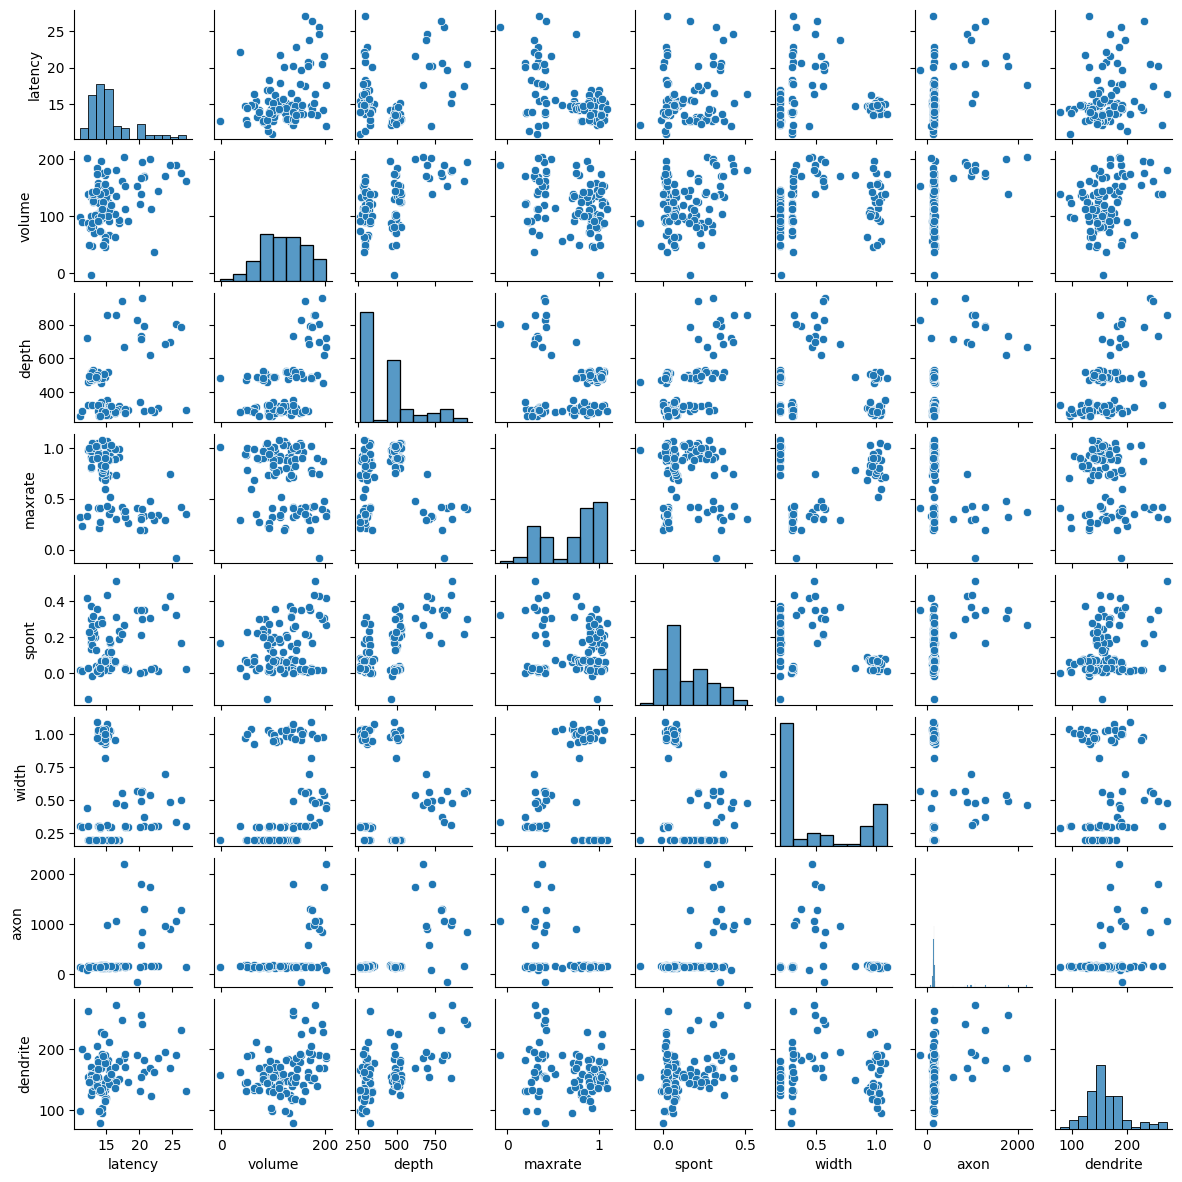

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # This is another plotting package, built really nicely for plotting these types of analyses!

sns.pairplot(dataset, height=1.5)
plt.show()

Clearly, there's a lot going on here. We'll want to use dimensionality reduction to try to understand if we can reduce the understanding of this dataset into a couple of different factors.

For now, we'll drop "transmission" from our dataframe -- we don't want to run PCA on it. Then, we'll normalize each column of data. Normalization isn't strictly *necessary* but it is a really useful for a dataset like this one where different variables have wildly different values (e.g., 0.5 to 300).

In [4]:
x_data = dataset.drop('transmission',axis=1)
x_data = (x_data - x_data.mean())/x_data.std()
# x_data = pd.DataFrame(stats.zscore(x_data)) # An alternative way to normalize
x_data.head()

,latency,volume,depth,maxrate,spont,width,axon,dendrite
0,-0.845411,0.267327,0.475991,0.311452,1.801119,-0.867176,-0.298761,-1.036417
1,-1.353490,-0.551551,-1.011360,-1.306932,-0.913933,-0.563226,-0.335639,-1.784675
2,1.477637,1.172510,2.034265,-1.749644,1.629965,-0.356545,2.628956,0.607171
3,-0.770023,0.084228,0.511222,1.159487,0.547869,-0.865241,-0.320605,-0.381476
4,-0.578024,-0.433363,0.303593,0.877206,1.671361,-0.867112,-0.341746,-0.200608


## Part 2. Perform PCA, manually.

### 1. Compute the covariance matrix.

Here, we'll calculate the **covariance** between the columns of our dataset. Similar to correlation, a positive covariance means these columns vary together, whereas a negative covariance means these columns vary in opposite directions.

For a more detailed direction of covariance and how it is computed, see [this video](https://youtube.com/watch?v=jcTq2PgU5Vw) and [this video](https://www.youtube.com/watch?v=g-Hb26agBFg). 

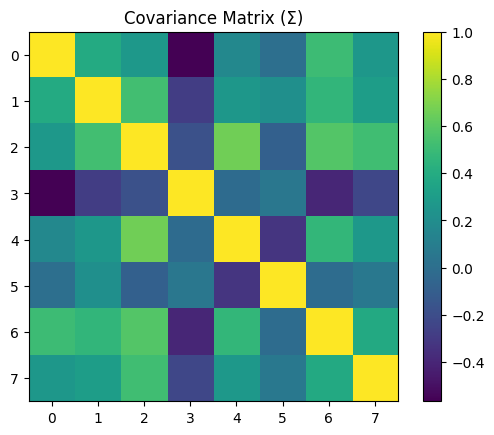

In [5]:
covDATA = x_data.cov()

plt.imshow(covDATA)
plt.colorbar()
plt.title('Covariance Matrix (\u03A3)')
plt.show()

### 2. Calculate the eigenvectors and extract the factors by rotation.
Determine the eigenvectors and eigenvalues of our covariance matrix. This **eigenvector decomposition** tells us the dimensions that are most useful for understanding our data.

The **eigenvectors** tell us the direction we need to stretch the data, the **eigenvalues** tell us *how much* we are stretching the data. We'll use a useful tool from the [numpy linear algebra package](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) to compute our eigenvectors and eigenvalues.

For a more detailed explaination of eigenvector decomposition, see [this video](https://www.youtube.com/watch?v=PFDu9oVAE-g). 

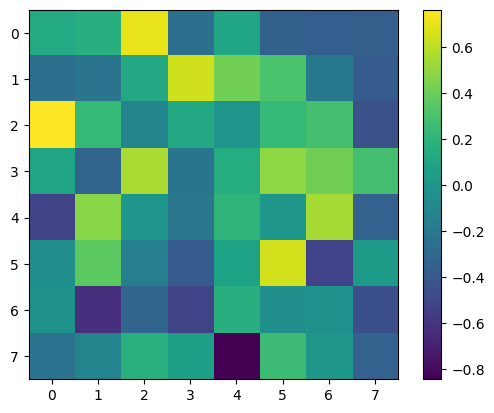

In [6]:
# Use the linalg.eigh to compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(covDATA)

plt.imshow(eigenvectors)
plt.colorbar()
plt.show()

In [7]:
# Check that the sum of our eigenvalues is 8 (the number of variables)
eigenSum = np.sum(eigenvalues)
print(eigenSum)

8.000000000000004


### 3. Determine the number of factors.
PCA will extract as many factors as there are variables, but we'd like to know how many of these factors are useful in explaining our data. 

There are a few different ways to do this (e.g., a Kaiser criterion), but here we'll use a "[Scree plot](https://en.wikipedia.org/wiki/Scree_plot)", and look for an "elbow" (very scientific, I know). Factors to the left of the elbow are considered meaningful, whereas factors to the right are considered noise.

We will first create the pca model, and then use the `pca.fit_transform()` method to both fit the model and project our data back into the extracted components.

In [8]:
# Import the PCA package
from sklearn.decomposition import PCA

pca = PCA() # Create a PCA model with 3 components
x_data_pca = pca.fit_transform(x_data)

Below, we'll plot our results.

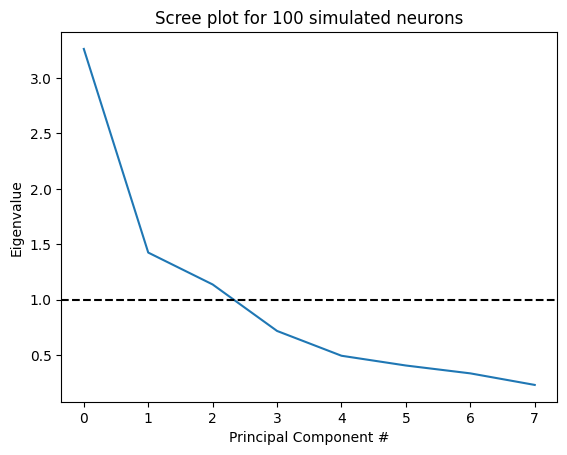

In [9]:
plt.plot(pca.explained_variance_ratio_*8) # Plot the expected variance as a function of the PC
plt.axhline(1,c='k',ls='--') # Plot a horizontal line at 1, the Kaiser criterion

plt.title('Scree plot for 100 simulated neurons')
plt.ylabel('Eigenvalue') 
plt.xlabel('Principal Component #')
plt.show()

Another way of looking at this is by plotting the cumulative variance explained by our principle components:

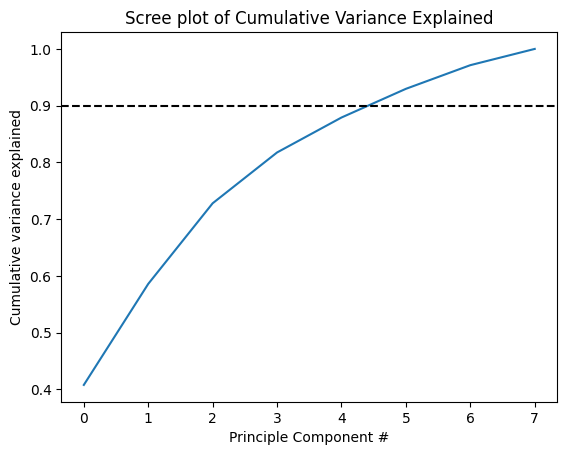

In [10]:
# Plot a cumulative sum of the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(.9,c='k',ls='--')
plt.title('Scree plot of Cumulative Variance Explained')
plt.ylabel('Cumulative variance explained')
plt.xlabel('Principle Component #')
plt.show()

As you can see, we would need five principle components to account for more than 90% of the variance in the dataset (which would be a lot).

In [11]:
# Another thing we can do is look at the explained variance for each PCA.
ex_variance=np.var(x_data_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.40793959 0.17803511 0.14203884 0.08955571 0.06156554 0.050551
 0.04168033 0.02863388]


### 3. Interpreting the meaning of factors.
This part is really tricky for neural data -- what counts as a *meaningful* factor for brain activity? This part is more or less easy depending on your data and how much you already know about it. 

For spike sorting, these factors are typically something obvious like spike amplitude or spike width, but for behavioral measures or population dynamics, the meaning of factors could be less obvious. Below, we can see how much each feature contributes to the first three PCs:

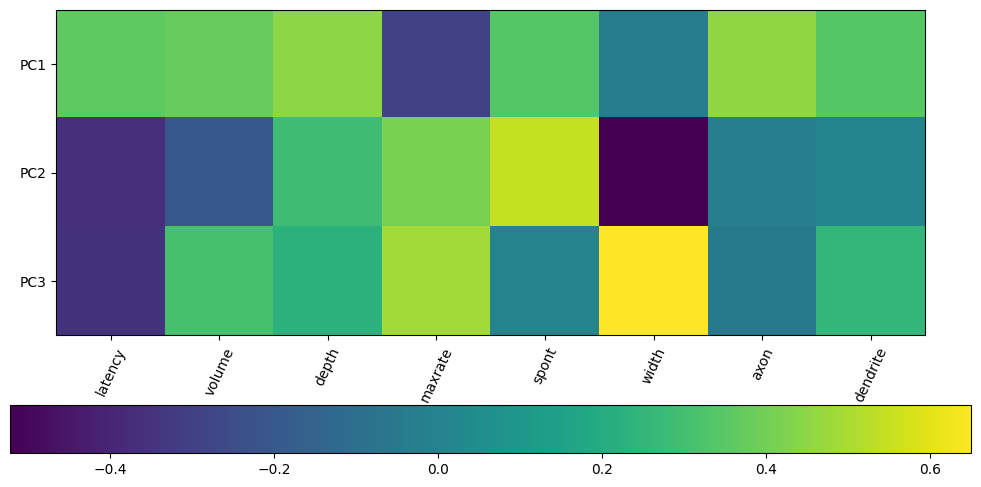

In [12]:
plt.figure(figsize=(10,5))
plt.imshow(pca.components_[:3],cmap='viridis',)
plt.yticks([0,1,2],['PC1','PC2','PC3'],fontsize=10)
plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.xticks(range(len(x_data.columns)),x_data.columns,rotation=65)

plt.show()

### 4. Determining the factor values of the original variables

Here, we'll plot the first two dimensions of our PCA.

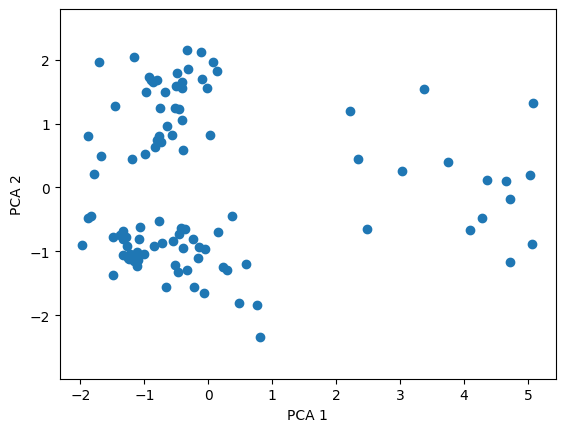

In [13]:
plt.figure()
plt.scatter(x_data_pca[:, 0], x_data_pca[:, 1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('equal')
plt.show()

## Step 3. Perform PCA, the straightforward way.
Thankfully, we don't need to go through *all* of those steps whenever we want to perform PCA in Python. Really, it comes down to three steps:

In [14]:
from sklearn.decomposition import PCA  # 1. Choose the model class (PCA) and import that package
pca = PCA()                            # 2. Instantiate the model with hyperparameters
X_2D = pca.fit_transform(x_data)       # 3. Fit the PCA model to our data and transform to two dimensions

Below, we'll plot our data using a useful function from seaborn, [lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html), which will allow us to color our datapoints by another variable, here, transmission type.

In [15]:
dataset.head()

,latency,volume,depth,maxrate,spont,width,axon,dendrite,transmission
0,12.702187,132.914624,520.705760,0.800139,0.374729,0.199383,160.339843,124.532215,inhibitory
1,10.965020,98.583961,261.797470,0.323374,0.020168,0.302280,146.068068,98.053089,inhibitory
2,20.644895,170.863569,791.959891,0.192954,0.352378,0.372249,1293.356104,182.695065,excitatory
3,12.959946,125.238397,526.838648,1.049965,0.211066,0.200038,151.886313,147.709085,inhibitory
4,13.616407,103.538847,490.695815,0.966806,0.357783,0.199404,143.704852,154.109603,inhibitory


In [16]:
dataset['PCA1'] = X_2D[:, 0]
dataset['PCA2'] = X_2D[:, 1]
dataset['PCA3'] = X_2D[:, 2]
dataset.head()

,latency,volume,depth,maxrate,spont,width,axon,dendrite,transmission,PCA1,PCA2,PCA3
0,12.702187,132.914624,520.705760,0.800139,0.374729,0.199383,160.339843,124.532215,inhibitory,0.074667,1.959743,-0.168284
1,10.965020,98.583961,261.797470,0.323374,0.020168,0.302280,146.068068,98.053089,inhibitory,-1.828359,-0.441677,-1.376799
2,20.644895,170.863569,791.959891,0.192954,0.352378,0.372249,1293.356104,182.695065,excitatory,4.367236,0.119674,-0.737770
3,12.959946,125.238397,526.838648,1.049965,0.211066,0.200038,151.886313,147.709085,inhibitory,-0.413302,1.648090,0.337540
4,13.616407,103.538847,490.695815,0.966806,0.357783,0.199404,143.704852,154.109603,inhibitory,-0.114169,2.121330,-0.026939


In [17]:
sns.lmplot("PCA1", "PCA2", hue='transmission', data=dataset, fit_reg=False)
plt.show()

TypeError: lmplot() got multiple values for argument 'data'

Remember the PCA didn't have any information on whether our cells were excitatory or inhibitory, but clearly it's picking up on features that also divide those cell types. And, it looks like excitatory and inhibitory cells actually might fall into three classes. Let's see what happens if we use *k*-means clustering on our data.

In [35]:
from sklearn.cluster import KMeans #Import the KMeans model

kmeans = KMeans(n_clusters=3) # Set up a kmeans model with 3 clusters

kmeans.fit(X_2D) # Fit our two dimensional data
y_kmeans = kmeans.predict(X_2D) 

Again, we'll use the `sns.lmplot()` method to nicely plot our data. Here, we'll color each point by its assigned *k*-means cluster.

/Users/ashley/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


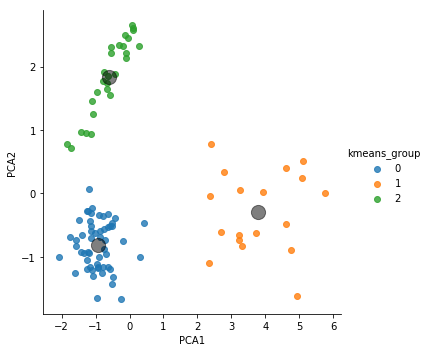

In [36]:
# Add our kmeans group to the data for plotting
dataset['kmeans_group'] = y_kmeans

sns.lmplot("PCA1", "PCA2", hue='kmeans_group', data=dataset, fit_reg=False)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [37]:
print(centers[:,0])
print(centers[:,1])

[-0.94079565  3.78816193 -0.6090057 ]
[-0.80785888 -0.28989969  1.83890492]


If we have tell *k*-means to use three clusters, it divides it up into three clusters. What happens if we tell it there are two clusters?

### Sidenote: What if we wanted to add another column to our dataframe, with a category we'd try to cluster with?

Let's say we want to create a new dataframe with a categorical column for the depth of cells to our dataframe. We'd use the syntax `df['new column name'] = pd.Series(index=dataset.index,dtype='int64')` to add an empty column with the same index and a specified datatype. We can then put 'shallow' or 'deep' in this column using the following syntax: `df.loc[condition, 'new column name'] = 'value'`:

In [38]:
dataset['depthCategory'] = pd.Series(index=dataset.index,dtype='int64')

dataset.loc[dataset['depth'] < 500, 'depthCategory'] = 'shallow'
dataset.loc[dataset['depth'] >= 500, 'depthCategory'] = 'deep'
dataset.head()

,latency,volume,depth,maxrate,spont,width,axon,dendrite,transmission,PCA1,PCA2,PCA3,kmeans_group,depthCategory
0,15.232010,113.255853,299.808284,0.882077,0.272622,0.198983,141.868908,133.461595,inhibitory,-0.960540,-1.107669,-0.818035,0,shallow
1,11.275057,105.231552,298.547427,0.379106,0.022283,0.298038,155.846848,171.377303,inhibitory,-1.237584,-0.278406,1.047163,0,shallow
2,14.696313,108.123692,310.407912,1.001500,0.334263,0.199106,161.315852,137.636029,inhibitory,-0.938894,-1.159347,-1.378928,0,shallow
3,25.047027,155.567002,309.697521,0.347535,0.012836,0.296320,148.584848,165.880021,inhibitory,0.414342,-0.470835,2.068303,0,shallow
4,13.189341,103.265886,474.088843,0.977470,0.092420,0.198617,164.502471,149.620023,inhibitory,-1.174234,-0.437223,-0.845270,0,shallow


## Step 4. Perform PCA on real electrophysiology data
We can also use PCA on time series data. Here, we'll work with a sample data set (data_for_exercises.mat) which you can download from [here](https://github.com/marius10p/NeuralDataScienceCSHL2019/blob/master/ByronYuExercises/data_for_exercises.mat). This dataset contains spike counts for 97 neurons recorded using an electrode array over the dorsal premotor cortex of a monkey during a reaching task. Each row of the dataset (728) is a different trial for a different angle of reaching (8 angles total). Trials 1-91 are for reach angle 1, 92-182 for reach angle 2, etc.

You can read more about the experiments that created this dataset [here](https://www.jneurosci.org/content/27/40/10742).

In [39]:
import scipy.io
from collections import defaultdict
import scipy.stats as sc

numChannels = 97
matIn = scipy.io.loadmat('data_for_exercises.mat')
spike_data = pd.DataFrame(matIn['Xplan'])

<div class="alert alert-success">

**Task**: Take a look at the raw electrophysiology data here by setting up a plot and looping through each row of `spike_data` to add it to the plot. Add a variable `y` which increases each time you run through a loop, allowing you to stack all of these traces (instead of plotting them on top of each other).

</div>

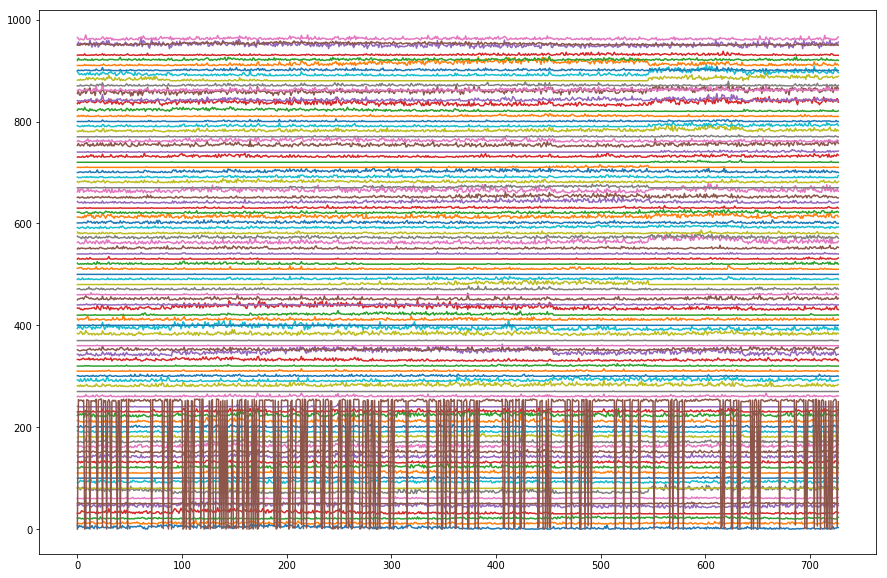

In [40]:
# Plot the raw data here
fig,ax = plt.subplots(figsize=(15,10))
y = 0

for neuron in spike_data:
    plt.plot(spike_data[neuron]+y)
    y = y+10 # 10 is arbitrary! This is just a way of spacing out our traces.
    
plt.show()

<div class="alert alert-success">

**Task**: Compute the PCA for these data and plot the results (with either `plt.scatter()` or `sns.lmplot()`. For this plot, you do not need a `color` or `hue` argument.

</div>

In [41]:
# Compute your PCA here
pca = PCA()
pca.fit(spike_data)
spike_2D = pca.transform(spike_data)

<div class="alert alert-success">

**Task**: As it notes above, *Each row of the dataset (728) is a different trial for a different angle of reaching (8 angles total). Trials 1-91 are for reach angle 1, 92-182 for reach angle 2, etc.* In the previous example of cell features, we colored our final PCA plot by whether the cell was excitatory or inhibitory. Here, we want to color each point on our PCA plot by the reach angle.

To do so, create a column in the spike_data frame called "angles", which contains a list of angle names (can simply be 1, 2, 3, etc. Then, go back to your plot and add this as the `hue` argument.

</div>

In [43]:
# Assign the angles column here
angles = []
angle_names = ['1','2','3','4','5','6','7','8']
angle_start = np.arange(0,728,91)
angle_end = np.arange(91,729,91)

for angle in range(8):
    for trial in range(angle_start[angle],angle_end[angle]):
        angles.append(angle_names[angle])

spike_data['angles'] = angles

spike_data.head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,angles
0,7,1,2,1,6,0,1,11,0,2,...,1,8,0,0,0,0,11,0,5,1
1,3,1,1,1,8,2,0,12,0,1,...,2,5,1,0,4,1,16,0,3,1
2,7,1,2,1,7,1,0,9,0,3,...,1,2,0,0,1,0,10,0,0,1
3,5,1,1,2,10,0,0,7,0,6,...,3,3,0,0,1,1,14,0,2,1
4,6,0,0,6,9,1,0,11,0,4,...,1,4,1,0,1,0,12,3,2,1


/Users/ashley/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


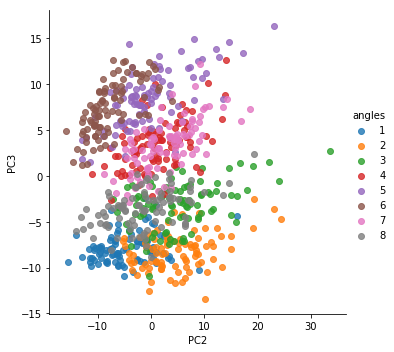

In [45]:
spike_data['PC1'] = spike_2D[:,0]
spike_data['PC2'] = spike_2D[:,1]
spike_data['PC3'] = spike_2D[:,2]

sns.lmplot('PC2','PC3',data = spike_data, hue = 'angles',fit_reg = False)

plt.show()